In [2]:
from utils_filter import *
from utils_datetime import *
from utils_geography import *
from dateutil import parser
from dateutil.relativedelta import relativedelta
from collections import Counter
import math
import cartopy.crs as ccrs
import xarray as xr
from scipy.spatial import KDTree
from geopy import distance

In [ ]:
data_location = 'data'
outlooks, pph, reports = read_datasets(data_location)

In [3]:
tz_conversions = {'PST': timedelta(hours=8),
                  'MST': timedelta(hours=7),
                  'CST': timedelta(hours=6),
                  'CSt': timedelta(hours=6),
                  'CSC': timedelta(hours=6),
                  'SCT': timedelta(hours=6),
                  'EST': timedelta(hours=5),
                  'ESt': timedelta(hours=5),
                  'PDT': timedelta(hours=7),
                  'MDT': timedelta(hours=6),
                  'CDT': timedelta(hours=5),
                  'EDT': timedelta(hours=4),
                  'HST': timedelta(hours=10),
                  'SST': timedelta(hours=11),
                  'GST': timedelta(hours=10),
                  'AKS': timedelta(hours=9),
                  'AST': timedelta(hours=4),
                  'UNK': timedelta(hours=5),
                  'GMT': timedelta(0)}

def get_reports_date_strings(date_times, timezones):
    # returns list of strings of date of given datetime and timezone (where day cutoffs are 12-12 UTC) formatted as 'YYYYMMDD0000'
    for datetime, timezone, i in zip(date_times, timezones, range(len(timezones))):
        #print(datetime + ' ' + timezone[:3])
        datetime = parser.parse(datetime)
        datetime = datetime + tz_conversions[timezone[:3]]
        #print(datetime)
        if (datetime.hour < 12):
            datetime = datetime - timedelta(days = 1)
        if datetime.year > 2049:
            datetime = datetime - relativedelta(years = 100)
        datetime = datetime.strftime("%Y%m%d") + '0000'
        if i == 0:
            ret = [datetime]
        else:
            ret.append(datetime)
    return ret

def get_pph_date_strings(times):
    # returns a list of strings of given dates formatted as 'YYYYMMDD0000'
    for datetime, i in zip(times, range(len(times))):
        string = datetime.dt.strftime("%Y%m%d").values + '0000'
        if i == 0:
            ret = [string]
        else:
            ret.append(string)
    return ret

In [4]:
reports['DATE'] = get_reports_date_strings(reports['BEGIN_DATE_TIME'], reports['CZ_TIMEZONE']) 
pph['time'] = get_pph_date_strings(pph.time) 
# subset outlooks into only one day 1, two day 2, and one day 3 categorical outlooks 
# day 3: cycle not -1. day 2: cycle not -1. Day 1: cycle 6. Category: categorical. # TODO: get prob by category 
#outlooks = outlooks[(((outlooks['DAY'] == 1) & (outlooks['CYCLE'] == 6)) | ((outlooks['DAY'] == 2) & (outlooks['CYCLE'] != -1)) | ((outlooks['DAY'] == 3) & (outlooks['CYCLE'] != -1)))
#        & (outlooks['CATEGORY'] == 'CATEGORICAL')]

# reset incicies
outlooks = outlooks.reset_index(drop=True)
reports = reports.drop(columns=['geometry'])

# Gridize reports

In [5]:
# filter reports to only be above severe thresholds

reports.loc[reports['MAGNITUDE'] == '', 'MAGNITUDE'] = 0
reports = reports[(reports['EVENT_TYPE'] == 'Tornado') | 
                  ((reports['EVENT_TYPE'] == 'Thunderstorm Wind') & (reports['MAGNITUDE'].astype(float) >= 50)) |
                  ((reports['EVENT_TYPE'] == 'Hail') & (reports['MAGNITUDE'].astype(float) >= 1))]

In [ ]:
# Create empty reports dataset: same coords and time, 3 hazard dimensions (and total dimension and T/F dimension?)
hazard_types= ['Wind', 'Hail', 'Tornado', 'Sig Wind', 'Sig Hail', 'Sig Tornado', 'Total Reports', 'Total Sig'] 

report_dataset = xr.Dataset(
    data_vars=dict(
        lat=(['y', 'x'], pph['lat'].data),
        lon=(['y', 'x'], pph['lon'].data)
    ),
    coords=dict(
        time=(['time'], pph['time'].data),
        x=(['x'], pph['x'].data),
        y=(['y'], pph['y'].data),
        hazard=(['hazard'], hazard_types)
    ),
    attrs=dict(description="Number of each hazard type",
            grid = pph.grid),
)

report_dataset = report_dataset.assign(count = (('time', 'y', 'x', 'hazard'), np.full((len(report_dataset['time']), len(report_dataset['y']), len(report_dataset['x']), len(hazard_types)), 0)))
report_dataset['count'].mean()

In [8]:
# https://www.nco.ncep.noaa.gov/pmb/docs/on388/tableb.html#GRID211 APPEARS TO SPECIFY
resolution = 81271
grid_shift = 52
cent_lon = pph['lon'].sel(y=0, x=grid_shift).values
cent_lat = pph['lat'].sel(y=0, x=grid_shift).values
sp = (25, 25)
data_crs = ccrs.LambertConformal(central_latitude = cent_lat, central_longitude=cent_lon, false_easting = 52*resolution, false_northing= 0, standard_parallels=sp)

In [9]:
kd_tree = KDTree(np.vstack((pph.lat.data.flatten(), pph.lon.data.flatten())).T)
row_len = pph.lat.shape[1]

In [ ]:
# iterate through reports (filtered to only be severe as in labelling), adding 1 to appropriate count 
#               (nearest point? or within 25 mi? would leave out reports in "gap" between 4 25 mi circles. probably within 25 mi for technically correct definition. But can do nearest point and then check within 25 mi.)
tree = True # if using nearest neighbor lookup rather than transforming to NCEP grid, should give same result

for i, row in reports.iterrows(): # for each report
    date = row['DATE']
    if i % 100000 == 0:
        print('Row ' + str(i))
    
    if (date >= report_dataset['time'][0]) and (date <= report_dataset['time'][-1]): # reports in time frame of interest
        # get grid points (x and y) of report location
        lon = row['BEGIN_LON']
        lat = row['BEGIN_LAT']
        if lon != '' and lat != '':
            if not tree:
                x, y = data_crs.transform_point(float(lon), float(lat), src_crs=ccrs.PlateCarree())
            else:
                # Look up nearest with scipy.spatial.KDTree
                index = kd_tree.query((float(lat), float(lon)))[1]
                x, y = (index % row_len, np.floor(index/row_len))
                xgrid, ygrid = x, y

            if not (math.isnan(x) or math.isnan(y) or float(lat) > 90):
                if not tree:
                    x, y = (x/resolution, y/resolution)
                    xgrid = round(x)
                    ygrid = round(y)

                # check if report is within 25 mi of nearest gridpoint
                if not tree:
                    within = np.sqrt((xgrid-x)**2 + (ygrid-y)**2) < .5 and xgrid >= 0 and xgrid <= 92 and ygrid >= 0 and ygrid <= 64 # half a grid point away is 25 miles
                else:
                    nearlat = kd_tree.data[index][0]
                    nearlon = kd_tree.data[index][1]
                    within = distance.distance((lat, lon), (nearlat, nearlon)).miles <= 25  
                
                if within:

                    if row['EVENT_TYPE'] == 'Thunderstorm Wind':
                        report_dataset['count'].loc[dict(time = date, x = xgrid, y = ygrid, hazard = 'Wind')] += 1
                        if float(row['MAGNITUDE']) >= 65:
                            report_dataset['count'].loc[dict(time = date, x = xgrid, y = ygrid, hazard = 'Sig Wind')] += 1

                    elif row['EVENT_TYPE'] == 'Hail':
                        report_dataset['count'].loc[dict(time = date, x = xgrid, y = ygrid, hazard = 'Hail')] += 1
                        if float(row['MAGNITUDE']) >= 2:
                            report_dataset['count'].loc[dict(time = date, x = xgrid, y = ygrid, hazard = 'Sig Hail')] += 1

                    elif row['EVENT_TYPE'] == 'Tornado':
                        report_dataset['count'].loc[dict(time = date, x = xgrid, y = ygrid, hazard = 'Tornado')] += 1
                        rating_str = row['TOR_F_SCALE']
                        if rating_str != 'EFU' and rating_str != '':
                            if int(rating_str[-1]) >= 2:
                                report_dataset['count'].loc[dict(time = date, x = xgrid, y = ygrid, hazard = 'Sig Tornado')] += 1

                    else:
                        raise Exception('Unexpected event type')
            

In [11]:
# Add total counts and T/F
report_dataset['count'].loc[dict(hazard = 'Total Reports')] = report_dataset['count'].sel(hazard = 'Wind') + report_dataset['count'].sel(hazard = 'Hail') + report_dataset['count'].sel(hazard = 'Tornado')
report_dataset['count'].loc[dict(hazard = 'Total Sig')] = report_dataset['count'].sel(hazard = 'Sig Wind') + report_dataset['count'].sel(hazard = 'Sig Hail') + report_dataset['count'].sel(hazard = 'Sig Tornado')
report_dataset = report_dataset.assign(bool = (('time', 'y', 'x', 'hazard'), (report_dataset['count'] > 0).data))

In [ ]:
save_location = 'data/storm_reports/grid_reports.nc'
report_dataset.to_netcdf(save_location)

# Messing around with projections

In [218]:
pph['p_perfect_wind'].sum()/100/grid_outlooks.sel(hazard = 'Wind')['bool'].sum()

<xarray.DataArray ()>
array(1.19078044)
Coordinates:
    hazard   <U4 'Wind'

In [153]:
grid_outlooks = xr.open_dataset('data/storm_reports/grid_reports.nc')

In [174]:
pph['p_perfect_tor'].isel(time = pph.time >= '200000000000').mean()/grid_outlooks.sel(hazard = 'Tornado')['bool'].isel(time = grid_outlooks.time >= '200000000000').mean()/100

<xarray.DataArray ()>
array(1.14602747)
Coordinates:
    hazard   <U7 'Tornado'

In [19]:
# https://www.nco.ncep.noaa.gov/pmb/docs/on388/tableb.html#GRID211 APPEARS TO SPECIFY
from pyproj import Proj, transform
pph = xr.open_dataset('data' + '/pph/' + 'labelled' + '_pph.nc')
resolution = 81271
x_shift = 52
y_shift = 50 # in this test, the central lon and lat come from grid point [52, 0] (or [53, 1], with one-based indexing) in the PPH dataset
cent_lon = pph['lon'].sel(y=y_shift, x=x_shift).values
cent_lat = pph['lat'].sel(y=y_shift, x=x_shift).values
sp = 25# standard parallel


In [20]:
arrx = np.zeros_like(pph['lat'])
arry = np.zeros_like(pph['lat'])

lcc_proj = Proj(proj='lcc', lat_1=sp, lat_2=sp, lat_0=cent_lat, lon_0=cent_lon, x_0=x_shift * resolution, y_0=y_shift*resolution, datum='WGS84')

for testx in range(93):
    for testy in range(65): # test x and test y (starting with [0, 0]) are the indecies of the grid point from PPH we are comparing against
        x, y = lcc_proj(pph['lon'].sel(x = testx, y = testy).values, pph['lat'].sel(x = testx, y = testy).values) # transforming the lat and lon at this gridpoint from PPH to our newly defined coordinate system should give back [x, y] 
        x, y = (x/resolution, y/resolution) # maybe there's something wrong with this?
        arrx[testy, testx] = x - testx
        arry[testy, testx] = y - testy



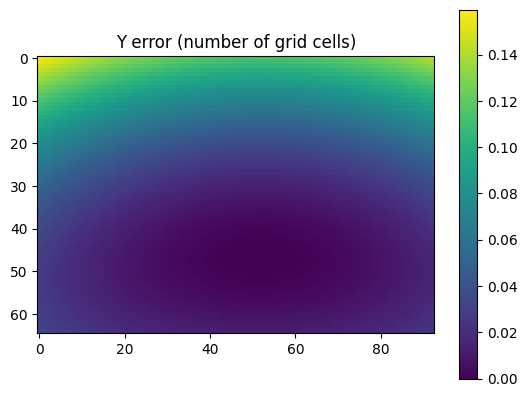

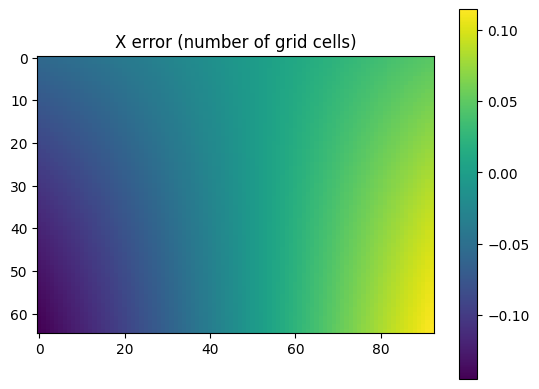

In [21]:
# displaying errors
im = plt.imshow(arry)
plt.title('Y error (number of grid cells)')
plt.colorbar(im)
plt.show()
im = plt.imshow(arrx)
plt.title('X error (number of grid cells)')
plt.colorbar(im)
plt.show()

In [10]:
go = xr.open_dataset('data/storm_reports/grid_reports.nc')

In [18]:
(go.lon.values - pph.lon.values).mean()

0.0

In [191]:
(pph.sel(time = '201104260000')['p_perfect_wind']/100).sum()

<xarray.DataArray 'p_perfect_wind' ()>
array(90.)
Coordinates:
    time     <U12 '201104260000'

In [192]:
go.sel(time = '201104260000', hazard = 'Wind')['bool'].sum()

<xarray.DataArray 'bool' ()>
array(76)
Coordinates:
    time     <U12 '201104260000'
    hazard   <U4 'Wind'

In [126]:
wpc = pd.read_csv('~/Downloads/2019_wind.csv')

In [127]:
ncei = pd.read_csv('~/Downloads/2019_ncei.csv')

 to fix: time window/binning

In [ ]:
ncei = ncei[(ncei['BEGIN_DATE_TIME'].str.startswith('20-MAY-19'))]

In [93]:
ncei = ncei[ncei['EVENT_TYPE'] == 'Thunderstorm Wind']

In [ ]:
wpc = wpc[wpc['date'] == '2019-05-20']

,om,yr,mo,dy,tz,stf,stn,mag,inj,fat,...,elon,len,wid,ns,sn,sg,f1,f2,f3,f4
count,64.000000,64.0,64.0,64.0,64.0,64.000000,64.0,64.00000,64.0,64.0,...,64.000000,64.0,64.0,64.0,64.0,64.0,64.000000,64.0,64.0,64.0
mean,664051.500000,2019.0,5.0,20.0,3.0,37.687500,0.0,56.84375,0.0,0.0,...,-93.395756,0.0,0.0,0.0,0.0,0.0,98.000000,0.0,0.0,0.0
std,18.618987,0.0,0.0,0.0,0.0,8.257512,0.0,7.97858,0.0,0.0,...,8.968220,0.0,0.0,0.0,0.0,0.0,79.606173,0.0,0.0,0.0
min,664020.000000,2019.0,5.0,20.0,3.0,20.000000,0.0,50.00000,0.0,0.0,...,-102.273200,0.0,0.0,0.0,0.0,0.0,7.000000,0.0,0.0,0.0
25%,664035.750000,2019.0,5.0,20.0,3.0,29.000000,0.0,52.00000,0.0,0.0,...,-99.087500,0.0,0.0,0.0,0.0,0.0,28.000000,0.0,0.0,0.0
50%,664051.500000,2019.0,5.0,20.0,3.0,40.000000,0.0,52.00000,0.0,0.0,...,-94.858450,0.0,0.0,0.0,0.0,0.0,80.000000,0.0,0.0,0.0
75%,664067.250000,2019.0,5.0,20.0,3.0,44.000000,0.0,61.00000,0.0,0.0,...,-93.370000,0.0,0.0,0.0,0.0,0.0,151.500000,0.0,0.0,0.0
max,664083.000000,2019.0,5.0,20.0,3.0,48.000000,0.0,82.00000,0.0,0.0,...,-69.560000,0.0,0.0,0.0,0.0,0.0,305.000000,0.0,0.0,0.0


In [110]:
kd_tree = KDTree(np.vstack((pph.lat.data.flatten(), pph.lon.data.flatten())).T)
row_len = pph.lat.shape[1]
# https://www.nco.ncep.noaa.gov/pmb/docs/on388/tableb.html#GRID211 APPEARS TO SPECIFY
resolution = 81271
grid_shift = 52
cent_lon = pph['lon'].sel(y=0, x=grid_shift).values
cent_lat = pph['lat'].sel(y=0, x=grid_shift).values
sp = (25, 25)
data_crs = ccrs.LambertConformal(central_latitude = cent_lat, central_longitude=cent_lon, false_easting = 52*resolution, false_northing= 0, standard_parallels=sp)

In [ ]:
report_dataset = xr.Dataset(
    data_vars=dict(
        lat=(['y', 'x'], pph['lat'].data),
        lon=(['y', 'x'], pph['lon'].data)
    ),
    coords=dict(
        x=(['x'], pph['x'].data),
        y=(['y'], pph['y'].data)
    ),
    attrs=dict(description="Number of each hazard type",
            grid = pph.grid),
)

report_dataset = report_dataset.assign(count = (('y', 'x'), np.full((len(report_dataset['y']), len(report_dataset['x'])), 0)))
report_dataset = report_dataset.assign(bool = (('y', 'x'), np.full((len(report_dataset['y']), len(report_dataset['x'])), 0)))

In [124]:
tree = True
for i, row in wpc.iterrows(): # for each report

    # get grid points (x and y) of report location
    
    #lon = row['BEGIN_LON']
    #lat = row['BEGIN_LAT']
    lon = row['elon']
    lat = row['elat']
    if lon != '' and lat != '':
        if not tree:
            x, y = data_crs.transform_point(float(lon), float(lat), src_crs=ccrs.PlateCarree())
        else:# Look up nearest with scipy.spatial.KDTree
            index = kd_tree.query((float(lat), float(lon)))[1]
            x, y = (index % row_len, np.floor(index/row_len))
            xgrid, ygrid = x, y

        if not (math.isnan(x) or math.isnan(y) or float(lat) > 90):

            if not tree:
                x, y = (x/resolution, y/resolution)
                xgrid = round(x)
                ygrid = round(y)

                # check if report is within 25 mi of nearest gridpoint
                within = np.sqrt((xgrid-x)**2 + (ygrid-y)**2) < .5 and xgrid >= 0 and xgrid <= 92 and ygrid >= 0 and ygrid <= 64 # half a grid point away is 25 miles
            else:
                nearlat = kd_tree.data[index][0]
                nearlon = kd_tree.data[index][1]
                within = distance.distance((lat, lon), (nearlat, nearlon)).miles <= 25  
            
            if within:
                report_dataset['count'].loc[dict(x = xgrid, y = ygrid)] += 1
                report_dataset['bool'].loc[dict(x = xgrid, y = ygrid)] = 1

In [ ]:
(report_dataset['count'] >= 1).sum() # DIFFERENT BECAUSE NOT ACCOUNTING FOR TIME ZONE OR WINDOW!

<xarray.DataArray 'count' ()>
array(28)

In [137]:
lat = pph.lat.values
lon = pph.lon.values

ny, nx = lat.shape

# Vertical distances: between (y, x) and (y+1, x)
vert_dist = np.zeros((ny-1, nx))
for j in range(ny-1):
    for i in range(nx):
        vert_dist[j, i] = distance.distance(
            (lat[j, i], lon[j, i]),
            (lat[j+1, i], lon[j+1, i])
        ).miles

# Horizontal distances: between (y, x) and (y, x+1)
horiz_dist = np.zeros((ny, nx-1))
for j in range(ny):
    for i in range(nx-1):
        horiz_dist[j, i] = distance.distance(
            (lat[j, i], lon[j, i]),
            (lat[j, i+1], lon[j, i+1])
        ).miles

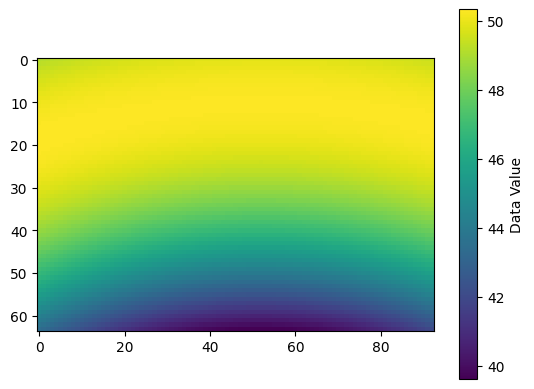

In [147]:
# Create the figure and axes
fig, ax = plt.subplots()

# Display the data as an image and get the ScalarMappable object
im = ax.imshow(vert_dist, cmap='viridis')

# Add the colorbar, referencing the ScalarMappable object
cbar = fig.colorbar(im, ax=ax)

# Optionally, add a label to the colorbar
cbar.set_label('Data Value')

# Display the plot
plt.show()

In [195]:
go.sel(time = '201905200000', hazard = 'Wind')['bool'].sum()

<xarray.DataArray 'bool' ()>
array(32)
Coordinates:
    time     <U12 '201905200000'
    hazard   <U4 'Wind'

In [214]:
pph.sel(time = '201905200000')['p_perfect_wind'].sum()

<xarray.DataArray 'p_perfect_wind' ()>
array(3400.)
Coordinates:
    time     <U12 '201905200000'

In [197]:
from scipy.ndimage import gaussian_filter

In [212]:
gaussian_filter(go.sel(time = '201905200000', hazard = 'Wind')['bool']*10000, sigma = 1.5, mode = 'nearest').sum()

319605

In [219]:
from skimage.draw import disk

In [332]:
rr, cc = disk((.5, .5), .75)
rr, cc

(array([0, 0, 1, 1], dtype=int64), array([0, 1, 0, 1], dtype=int64))

In [341]:
t = '200509140000'
pph.sel(time = t)['p_perfect_tor'].sum().values, go.sel(time = t, hazard = 'Tornado')['bool'].sum().values

(array(100.), array(0))

In [303]:
go.sel(time = '201905200000', hazard = 'Tornado')['bool'].sum().values == 20

True

In [313]:
for d in pph['time'][8800:]:
    if (pph.sel(time = d)['p_perfect_tor'].sum().values >= 400) and (go.sel(time = d, hazard = 'Tornado')['bool'].sum().values == 1):
        print(d)
# sometimes two reports out of one!

<xarray.DataArray 'time' ()>
array('200406180000', dtype='<U12')
Coordinates:
    time     <U12 '200406180000'
<xarray.DataArray 'time' ()>
array('200408210000', dtype='<U12')
Coordinates:
    time     <U12 '200408210000'
<xarray.DataArray 'time' ()>
array('200408240000', dtype='<U12')
Coordinates:
    time     <U12 '200408240000'
<xarray.DataArray 'time' ()>
array('200605260000', dtype='<U12')
Coordinates:
    time     <U12 '200605260000'
<xarray.DataArray 'time' ()>
array('200705140000', dtype='<U12')
Coordinates:
    time     <U12 '200705140000'
<xarray.DataArray 'time' ()>
array('200712200000', dtype='<U12')
Coordinates:
    time     <U12 '200712200000'
<xarray.DataArray 'time' ()>
array('200902110000', dtype='<U12')
Coordinates:
    time     <U12 '200902110000'


KeyboardInterrupt: 

Discrepency example: 200509140000 tornado report

In [350]:
reports = pd.read_csv('data/storm_reports/all_reports.csv') # from NCEI
reports = pd.read_csv('~/Downloads/2005-2007_torn.csv') # from WCM

C:\Users\miles\AppData\Local\Temp\ipykernel_7052\1530049038.py:1: DtypeWarning: Columns (6,15,16,18,22,23,25,27,28,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  reports = pd.read_csv('data/storm_reports/all_reports.csv') # from NCEI


In [351]:
t = '200509140000'
pph.sel(time = t)['p_perfect_tor'].sum().values, go.sel(time = t, hazard = 'Tornado')['bool'].sum().values

(array(100.), array(0))

In [354]:
#reports[(reports['DATE'] == '2005-09-14') & (reports['EVENT_TYPE'] == 'Tornado')]
reports[(reports['date'] == '2005-09-14')]

,om,yr,mo,dy,date,time,tz,st,stf,stn,...,len,wid,ns,sn,sg,f1,f2,f3,f4,fc
957,411,2005,9,14,2005-09-14,17:08:00,3,TX,48,103,...,1.0,40,1,1,1,155,0,0,0,0


In [355]:
#lat = reports[(reports['DATE'] == '2005-09-14') & (reports['EVENT_TYPE'] == 'Tornado')].BEGIN_LAT.values[0] # '2005-09-14'
#lon = reports[(reports['DATE'] == '2005-09-14') & (reports['EVENT_TYPE'] == 'Tornado')].BEGIN_LON.values[0]

lat = reports[(reports['date'] == '2005-09-14')].slat.values[0] # '2005-09-14'
lon = reports[(reports['date'] == '2005-09-14')].slon.values[0]

In [356]:
lat, lon

(33.85, -99.75)

In [357]:
mindist = np.inf
for x in pph['x']:
    for y in pph['y']:
        latp = pph['lat'].sel(x = x, y = y)
        lonp = pph['lon'].sel(x = x, y = y)
        dist = distance.distance((lat, lon), (latp, lonp)).miles
        if dist < mindist:
            mindist = dist
            savex = x
            savey = y

In [358]:
mindist

33.94122045457204

In [359]:
pph.sel(x = slice(45, 48), y = slice(22, 24))

<xarray.Dataset>
Dimensions:              (time: 16436, x: 4, y: 3)
Coordinates:
  * time                 (time) object '197901010000' ... '202312310000'
  * x                    (x) float64 45.0 46.0 47.0 48.0
  * y                    (y) float64 22.0 23.0 24.0
Data variables: (12/85)
    lat                  (y, x) float64 33.44 33.47 33.5 ... 34.92 34.94 34.96
    lon                  (y, x) float64 -101.1 -100.2 -99.33 ... -99.39 -98.51
    p_perfect_wind       (time, y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    p_perfect_sig_wind   (time, y, x) float64 ...
    p_perfect_hail       (time, y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    p_perfect_sig_hail   (time, y, x) float64 ...
    ...                   ...
    ETS_T_NUM            (time) float64 ...
    ETS_NUM              (time) float64 ...
    TSS_W_NUM            (time) float64 ...
    TSS_H_NUM            (time) float64 ...
    TSS_T_NUM            (time) float64 ...
    TSS_NUM              (time) float64 ...
Attributes:
    title:         Practically Perfect Wind Hindcasts
    grid:          80-km NCEP 211
    sigma:         1.5
    author:        Dr. Victor Gensini
    author_email:  vgensini@niu.edu
    citation:      https://doi.org/10.1175/BAMS-D-19-0321.1